In [ ]:
import copy
import time
import os, sys
import shutil
import json
import numpy as np

import chainer
from chainer import cuda

from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import elecpy.elecpy as elp
from elecpy.util.cmap_bipolar import bipolar
from elecpy.elecpySession import ElecpySession

from IPython.display import HTML

from opmap.videoData import VideoData
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap

from scipy.signal import argrelmax
from numba.decorators import autojit

%matplotlib inline


In [67]:
from util import *
import datetime

# シミュレーション実行

In [ ]:
# load sample parameter
with open ('sim_params_org.json','r') as f:
    sim_params = json.load(f)

# modify parameters
sim_params['time']['end'] = 1000
sim_params["stimulation"] = {}
#sim_params["stimulation"]["extracellular"][0]["start"] = 0.
#sim_params["stimulation"]["extracellular"][0]["duration"] = 10.
sim_params['log']['path'] = '/mnt/recordings/SimulationResult/20180616-1'

sim_params['geometory']['height'] = 200
sim_params['geometory']['width'] = 200

sim_params['restart'] = {}
sim_params['restart']['count'] = 0
#sim_params['restart']['source'] = "/mnt/recordings/SimulationResult/20170809-4/"
#sim_params['restart']['source'] = "/mnt/recordings/SimulationResult/20180524-2/"
sim_params['restart']['source'] = "/mnt/recordings/SimulationResult/20171128-1/"

print json.dumps(sim_params, indent=4)

In [ ]:
#!sed --help
!sed -i s/"'gna_'         : 12.0"/"'gna_'         : 10.0"/ elecpy/cell/mahajan/const.py 

In [ ]:
g = elp.sim_generator(sim_params)

In [ ]:
os.mkdir(sim_params['log']['path'] )

In [66]:
out = []
while True:
    img = g.next()
    if img is False: break
    out.append(np.copy(img))

------------------340.0ms
------------------341.0ms
------------------342.0ms
------------------343.0ms
------------------344.0ms
------------------345.0ms
------------------346.0ms
------------------347.0ms
------------------348.0ms
------------------349.0ms
------------------350.0ms
------------------351.0ms
------------------352.0ms
------------------353.0ms
------------------354.0ms
------------------355.0ms
------------------356.0ms
------------------357.0ms
------------------358.0ms
------------------359.0ms
------------------360.0ms
------------------361.0ms
------------------362.0ms
------------------363.0ms
------------------364.0ms
------------------365.0ms
------------------366.0ms
------------------367.0ms
------------------368.0ms
------------------369.0ms
------------------370.0ms
------------------371.0ms
------------------372.0ms
------------------373.0ms
------------------374.0ms
------------------375.0ms
------------------376.0ms
------------------377.0ms
------------

## Check results

In [82]:
sess = load_sess(
    "/mnt/recordings/SimulationResult/20180616-1",
    0, 100,
    100, 120, 
    90, 110,
    save_dir,
)


In [83]:
frame = 80

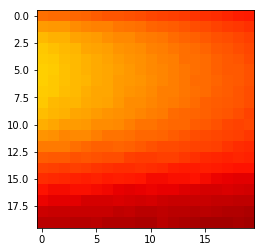

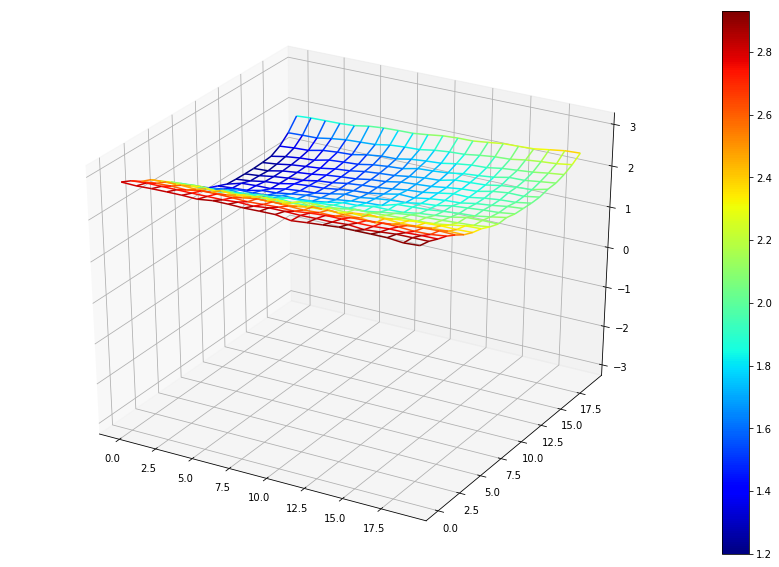

In [78]:
Y_S, Y_E = (0,200)
X_S, X_E = (0,200)

In [79]:
sess_org = ElecpySession("/mnt/recordings/SimulationResult/20180616-1")

#sess_org.data['tone'] *= (sess_org.data['tone']>0.0)*1

In [80]:
sess_org.data['vmem'].shape

(1001, 200, 200)

In [81]:
for key in sess_org.data.keys():
    sess_org.data[key] = sess_org.data[key][:,Y_S:Y_E,X_S:X_E]

#phase map
cam = VideoData(*sess_org.data['vmem'].shape)
cam.data = - sess_org.data['vmem']
vmem = VmemMap(cam)
del(cam)
pmap = PhaseMap(vmem, width = vmem.data.shape[2])
vmem.saveImage( os.path.join(save_dir, 'vmem')); del(vmem)
pmap.data = - pmap.data
sess_org.data['phase'] = pmap.data
pmap.saveImage( os.path.join(save_dir, 'pmap')); del(pmap)

#cell params
sess_org.data['stim'] = -sess_org.data['cell/xina']#+sess.data['tone']
sess_org.data['hj'] = sess_org.data['cell/h']*sess_org.data['cell/j']
sess_org.data['gate'] = sess_org.data['hj']*sess_org.data['cell/m']*sess_org.data['cell/m']*sess_org.data['cell/m']

### ミアンダリング経路

In [ ]:
T_S, T_E = (100,220)
sess = copy.deepcopy(sess_org)
for key in sess.data.keys():
    sess.data[key] = sess_org.data[key][T_S:T_E,:,:]

In [ ]:
pmap = sess.data['phase']
pmap_diff = copy.deepcopy(pmap)

for f in range(len(pmap_diff)):
    if f == 0: continue
    pmap_diff[f,:,:] = pmap[f,:,:] - pmap[f-1,:,:]

def phaseComplement(value):
    value -= (value > np.pi)*2*np.pi
    value += (value < - np.pi)*2*np.pi
    return value
    
pmap_diff = phaseComplement(-pmap_diff)

sess.data['psum'] = np.sum(pmap_diff[80:120], axis=0)

plt.imshow(sess.data['psum'], cmap='gray', vmin=0, vmax=2*np.pi)
plt.colorbar()

#pmap_mask.saveImage( os.path.join(save_dir, 'pmap_mask'))

In [ ]:
def pixelwise_open(sess):
    L,M,N = sess.data['tone'].shape
    sess.data['open'] = np.zeros_like(sess.data['gate'])
    for i in range(M):
        for j in range(N):
            gate = sess.data['gate'][:,i,j]
            peaks = argrelmax(gate, order=30)[0]            
            for p in peaks:
                sess.data['open'][p:,i,j] = p
            for n in range(L):
                sess.data['open'][n,i,j] *= -1
                sess.data['open'][n,i,j] += n
autojit(pixelwise_open)(sess)

L,M,N = sess.data['tone'].shape
b = np.ones(10)
prs = []
for y in range(M):
    for x in range(N):
        tone = sess.data['tone'][:,y,x]
        tone_conv = convolve(tone, b, 'same')
        peaks = argrelmax(tone_conv, order=30)[0]
        if len(peaks) > 1:
            t = peaks[-1]
            prs.append([t, sess.data['open'][t,y,x], tone_conv[t], sess.data['psum'][y,x], ((sess.data['psum']>1.*np.pi)*1)[y,x]])   
prs = np.array(prs)
prs_1 = prs

plt.scatter(prs[:,1], prs[:,2], c=prs[:, 4], cmap='jet', vmin=0, vmax= 1)
#plt.xlim([0, prs[:,1].max()])

## passive

In [ ]:
T_S, T_E = (420,540)
sess = copy.deepcopy(sess_org)
for key in sess.data.keys():
    sess.data[key] = sess_org.data[key][T_S:T_E,:,:]

In [ ]:
pmap = sess.data['phase']
pmap_diff = copy.deepcopy(pmap)

for f in range(len(pmap_diff)):
    if f == 0: continue
    pmap_diff[f,:,:] = pmap[f,:,:] - pmap[f-1,:,:]

def phaseComplement(value):
    value -= (value > np.pi)*2*np.pi
    value += (value < - np.pi)*2*np.pi
    return value
    
pmap_diff = phaseComplement(-pmap_diff)

sess.data['psum'] = np.sum(pmap_diff[80:120], axis=0)

plt.imshow(sess.data['psum'], cmap='gray', vmin=0, vmax=2*np.pi)
plt.colorbar()

#pmap_mask.saveImage( os.path.join(save_dir, 'pmap_mask'))

In [ ]:
def pixelwise_open(sess):
    L,M,N = sess.data['tone'].shape
    sess.data['open'] = np.zeros_like(sess.data['gate'])
    for i in range(M):
        for j in range(N):
            gate = sess.data['gate'][:,i,j]
            peaks = argrelmax(gate, order=30)[0]            
            for p in peaks:
                sess.data['open'][p:,i,j] = p
            for n in range(L):
                sess.data['open'][n,i,j] *= -1
                sess.data['open'][n,i,j] += n
autojit(pixelwise_open)(sess)

L,M,N = sess.data['tone'].shape
b = np.ones(10)
prs = []
for y in range(M):
    for x in range(N):
        tone = sess.data['tone'][:,y,x]
        tone_conv = convolve(tone, b, 'same')
        peaks = argrelmax(tone_conv, order=30)[0]
        if len(peaks) > 1:
            t = peaks[-1]
            prs.append([t, sess.data['open'][t,y,x], tone_conv[t], sess.data['psum'][y,x], ((sess.data['psum']>1.*np.pi)*1)[y,x]])   
prs = np.array(prs)
prs_2 =  prs

plt.scatter(prs[:,1], prs[:,2], c=prs[:, 4], cmap='jet', vmin=0, vmax=1)
#plt.xlim([0, prs[:,1].max()])

In [ ]:
plt.scatter(prs_1[:,1], prs_1[:,2], c=prs_1[:, 4], cmap='jet', vmin=0, vmax=1)
plt.scatter(prs_2[:,1], prs_2[:,2], c=prs_2[:, 4], cmap='jet', vmin=0, vmax=1)

# misc

In [ ]:
from scipy.signal import convolve

b = np.ones(10)

plt.figure(figsize=(5,30))

x = 10

prs = []

for n, y in enumerate(Y):
    plt.subplot(len(Y),1,n+1)
    tone = sess.data['tone'][:,y,x]
    tone_conv = convolve(tone, b, 'same')
    plt.plot(tone)
    plt.plot(tone_conv)
    plt.ylim([0.0, 0.1])
    
    peaks = argrelmax(tone_conv, order=30)[0]
    plt.vlines(peaks, 0.0, 0.1)
    
    t = peaks[-1]
    prs.append([t, sess.data['open'][t,y,x], tone_conv[t], pmap_sum[y,x], ((pmap_sum>1.*np.pi)*1)[y,x]])
    
prs = np.array(prs)
prs.astype('int')

In [ ]:
plt.scatter(prs[:,1], prs[:,2], c=prs[:, 4], cmap='jet')

In [ ]:
#sess_norm = sess.getNormalized()

plt.figure(figsize=(15,30))

x = 10
Y = range(0,20,1)
keys = ['vmem', 'phase', 'gate', 'open', 'tone']

for n, y in enumerate(Y):
    
    tone = sess.data['tone'][:,y,x]
    peaks = argrelmax(convolve(tone, b, 'same'), order=30)[0]
    
    for m, key in enumerate(keys):

        plt.subplot(len(Y),len(keys),n*len(keys)+m+1)

        plt.plot(sess.data[key][:,y,x], label=key)

        plt.ylim([sess.data[key].min(), sess.data[key].max()])
        
        plt.vlines(peaks, sess.data[key].min(), sess.data[key].max(), "black", linestyles='dashed')


In [ ]:
pmap = sess.data['phase']

dst_dir = os.path.join(save_dir, 'pplot')
if not os.path.exists(dst_dir): os.mkdir(dst_dir)

for i, t in enumerate(range(pmap.shape[0])):

    fig = plt.figure()
    ax = plt.axes()
    c = patches.Circle(xy=(0,0), radius=1.0, fill=False, ec='#000000')
    ax.add_patch(c)

    #plot_phase(np.arange(-np.pi, np.pi, np.pi/4))

    phase = pmap[t,:9,x]
    plt.scatter(np.cos(phase), np.sin(phase))
    phase = pmap[t,9:,x]
    plt.scatter(np.cos(phase), np.sin(phase))

    plt.title('{0}'.format(t))
    #plt.axis('scaled')
    ax.set_aspect('equal')
    
    plt.savefig('{0}/{1:0>4}.png'.format(dst_dir, i))

In [ ]:
#!ffmpeg -r 15 -y -i "/mnt/recordings/AnalysisResult/Tomii/2018-05-25/%04d.png" -vcodec rawvideo "/mnt/recordings/AnalysisResult/Tomii/2018-05-25/out.avi"

In [ ]:
img_na = np.max((sess.data['stim'] > 5)*1, axis=0)
plt.imshow(img_na, cmap='gray')
plt.colorbar()

# img_gate = np.max((sess.data['gate']>0.002)*1, axis=0)
# plt.imshow(img_gate, cmap='gray')
# plt.colorbar()

In [ ]:
def pixelwise_peak_analysis(stim):
    L,M,N = stim.shape
    ret = []
    for i in range(M):
        for j in range(N):
            peaks = argrelmax( stim[:,i,j], order=50 )[0]
            if len(peaks) > 1:
                for k, p in enumerate(peaks):
                    if k == 0: continue
                    #hj = sess.data['cell/h'][p,i,j]*sess.data['cell/j'][p,i,j]
                    interval = peaks[k] - peaks[k-1]
                    if interval < 80:
                        s = np.sum(sess.data['tone'][p-R:p+R,i,j])
                        ina = np.sum(1.0 - sess.data['cell/xina'][p-R:p+R, i, j])
                        ret.append([p, i, j, interval, s, ina])
    return np.array(ret)

arr = autojit(pixelwise_peak_analysis)( sess.data['tone'] )

In [ ]:
#arr = pixelwise_peak_analysis( sess.data['tone'][:, 75:125, 75:125] )
arr = pixelwise_peak_analysis( sess.data['tone'][:, :105, 95:105] )
arr.shape